Последнее, что мы попробуем по части word2vec эмбеддингов, это модель **doc2vec**.

Doc2vec преобразует текстовые документы в числовые векторы, сохраняя их семантическое значение. Только он работает не на уровне слова, а всего текста. Он обучается примерно так же, как и word2vec, но при обучении дополнительно создается вектор документа, который той же размерности, что и вектора слов, но это на самом деле такое "псевдослово", которое побывало в контексте каждого из слов в документе. В итоге вектор документа "учится" представлять общий смысл документа, так как он участвует в предсказании каждого слова.

При этом, конечно, не нужно привязываться к cлову "документ". Делить можно, например, и по параграфам, главам и прочему.

1. Такой подход улучшает работу **классификации текстов** (помните, мы классифицировали на спам/не спам, делая BOW-вектора? А так будет ещё умнее!).
2. Его можно применять в работе **рекомендательных систем**, например, подбирая похожие описания товаров.
3. Можно в принципе сравнивать, насколько похоже тексты. А затем **кластеризовать** их.

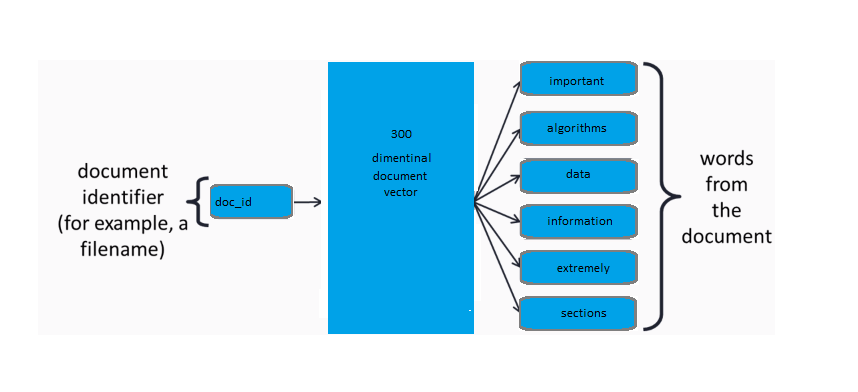

NB! Как и со словами, качество, конечно, сильно зависит от обучающего корпуса.

У doc2vec есть два основных варианта реализации:
1. **PV-DM** (Distributed Memory), алгоритм предсказывает слова по его окружению (только с учетом вектора документа).
2. **PV-DBOW** (Distributed Bag of Words), предсказание токена только по вектору документа, игнорируя контекст.

Будем пользоваться той же моделью, с которой мы уже работали, чтобы посравнивать некоторые простые тексты.

In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from pymorphy3 import MorphAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import os
from tqdm import tqdm
morph = MorphAnalyzer()
stopwords_ru = stopwords.words('russian')
stopwords_eng = stopwords.words('english')
import random
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import os

В самом просто виде это выглядит так (взято из этого тьюториала: https://www.geeksforgeeks.org/doc2vec-in-nlp/):

In [ ]:
# define a list of documents.
data = ["This is the first document",
        "This is the second document",
        "This is the third document",
        "This is the fourth document"]

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(data)]

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=2, epochs=50)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
document_vectors = [model.infer_vector(
    word_tokenize(doc.lower())) for doc in data]

#  print the document vectors
for i, doc in enumerate(data):
    print("Document", i+1, ":", doc)
    print("Vector:", document_vectors[i])
    print()

Дальше осталось только построить матрицу:

In [ ]:
similarity_matrix = cosine_similarity(document_vectors)
similarity_matrix

И график:

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=[f"Doc {i+1}" for i in range(len(data))], 
            yticklabels=[f"Doc {i+1}" for i in range(len(data))], cmap="YlGnBu")
plt.title("Косинусное сходство между текстами")
plt.show()

Посмотрим на текстах, которые должны быть похожи, ведь они выражают любовь:

In [ ]:
texts_of_love = ['Александр Пушкин завораживает своим поэтическим гением, в каждом слове которого дышит вечная красота и глубина русской души.',
                 'Николай Гоголь пленяет своим ярким юмором и фантастической образностью, раскрывая абсурд и величие человеческой природы.',
                 'Лев Толстой покоряет масштабом мысли, заставляя задуматься о смысле жизни и нравственных идеалах через его эпические полотна.',
                 'Фёдор Достоевский проникает в самые тёмные уголки души, открывая сложность человеческой природы с поразительной психологической глубиной.',
                 'Сергей Аксаков очаровывает тёплой искренностью и любовью к родной природе, создавая живые картины русской жизни.',
                 'Николай Чернышевский вдохновляет своим стремлением к справедливости и верой в преобразующую силу разума и идей.'
    ]

Немного предобработаем:

In [ ]:
tagged_texts_of_love = []
for text in texts_of_love:
    text = re.sub(r'[\.]', '', text)
    tagged_text = [str(morph.parse(token)[0].normal_form) + '_' + str(morph.parse(token)[0].tag.POS) for token in word_tokenize(text) if token not in stopwords_ru]
    tagged_texts_of_love.append(' '.join(tagged_text))
tagged_texts_of_love

In [ ]:
tagged_data = [TaggedDocument(words=word_tokenize(text),
                              tags=[str(i)]) for i,
               text in enumerate(tagged_texts_of_love)]

model = Doc2Vec(vector_size=20, min_count=1, epochs=50)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

love_document_vectors = [model.infer_vector(word_tokenize(text)) for text in tagged_texts_of_love]

similarity_love_matrix = cosine_similarity(love_document_vectors)

names = ['Пушкин', 'Гоголь', 'Толстой', 'Достоевский', 'Аксаков', 'Чернышевский']
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_love_matrix, annot=True, xticklabels=[f"{names[i]}" for i in range(len(tagged_data))], 
            yticklabels=[f"{names[i]}" for i in range(len(tagged_data))], cmap="YlGnBu")
plt.title("Косинусное сходство между текстами")
plt.show()

Можем немного изменить градус нашей любви к великим русским писателям, чтобы тексты были чуть более похожими:

In [ ]:
texts_of_love_s = ['Александр Пушкин восхищает поэтическим гением, в каждом слове которого раскрывается красота и глубина русской души.',
                   'Николай Гоголь восхищает ярким юмором и фантастической образностью, раскрывая величие и противоречия человеческой природы.',
                   'Лев Толстой восхищает масштабом мысли, раскрывая смысл жизни и нравственные идеалы через эпические произведения.',
                   'Фёдор Достоевский восхищает глубоким проникновением в душу, раскрывая сложность человеческой природы с психологической точностью.',
                   'Сергей Аксаков восхищает искренней любовью к природе, раскрывая живые и тёплые картины русской жизни.',
                   'Николай Чернышевский восхищает стремлением к справедливости, раскрывая силу разума и преобразующих идей.'
    ]

tagged_texts_of_love_s = []
for text in texts_of_love_s:
    text = re.sub(r'[\.]', '', text)
    tagged_text = [str(morph.parse(token)[0].normal_form) + '_' + str(morph.parse(token)[0].tag.POS) for token in word_tokenize(text) if token not in stopwords_ru]
    tagged_texts_of_love_s.append(' '.join(tagged_text))

tagged_data = [TaggedDocument(words=word_tokenize(text),
                              tags=[str(i)]) for i,
               text in enumerate(tagged_texts_of_love_s)]

model = Doc2Vec(vector_size=20, min_count=1, epochs=50)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

love_document_vectors = [model.infer_vector(word_tokenize(text)) for text in tagged_texts_of_love]

similarity_love_matrix = cosine_similarity(love_document_vectors)

names = ['Пушкин', 'Гоголь', 'Толстой', 'Достоевский', 'Аксаков', 'Чернышевский']
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_love_matrix, annot=True, xticklabels=[f"{names[i]}" for i in range(len(tagged_data))], 
            yticklabels=[f"{names[i]}" for i in range(len(tagged_data))], cmap="YlGnBu")
plt.title("Косинусное сходство между текстами")
plt.show()

Тексты стали более похожими, конечно, и как люди мы понимаем, что они в общем-то достаточно похожи. Всё дело, конечно, в малом объеме информации, токенов, контекстов их употребления. Но вообще здесь нет твердой почвы, чтобы понять, действительно ли они так похожи? Можно подать достаточно большие тексты, это немного исправит положение:

In [ ]:
texts = ["Plants are the eukaryotes that form the kingdom Plantae; they are predominantly photosynthetic. This means that they obtain their energy from sunlight, using chloroplasts derived from endosymbiosis with cyanobacteria to produce sugars from carbon dioxide and water, using the green pigment chlorophyll. Exceptions are parasitic plants that have lost the genes for chlorophyll and photosynthesis, and obtain their energy from other plants or fungi. Most plants are multicellular, except for some green algae. Historically, as in Aristotle's biology, the plant kingdom encompassed all living things that were not animals, and included algae and fungi. Definitions have narrowed since then; current definitions exclude fungi and some of the algae. By the definition used in this article, plants form the clade Viridiplantae (green plants), which consists of the green algae and the embryophytes or land plants (hornworts, liverworts, mosses, lycophytes, ferns, conifers and other gymnosperms, and flowering plants). A definition based on genomes includes the Viridiplantae, along with the red algae and the glaucophytes, in the clade Archaeplastida. There are about 380,000 known species of plants, of which the majority, some 260,000, produce seeds. They range in size from single cells to the tallest trees. Green plants provide a substantial proportion of the world's molecular oxygen; the sugars they create supply the energy for most of Earth's ecosystems, and other organisms, including animals, either eat plants directly or rely on organisms which do so. Grain, fruit, and vegetables are basic human foods and have been domesticated for millennia. People use plants for many purposes, such as building materials, ornaments, writing materials, and, in great variety, for medicines. The scientific study of plants is known as botany, a branch of biology.",
         "In botany, a tree is a perennial plant with an elongated stem, or trunk, usually supporting branches and leaves. In some usages, the definition of a tree may be narrower, e.g., including only woody plants with secondary growth, only plants that are usable as lumber, or only plants above a specified height. But wider definitions include taller palms, tree ferns, bananas, and bamboos. Trees are not a monophyletic taxonomic group but consist of a wide variety of plant species that have independently evolved a trunk and branches as a way to tower above other plants to compete for sunlight. The majority of tree species are angiosperms or hardwoods; of the rest, many are gymnosperms or softwoods. Trees tend to be long-lived, some trees reaching several thousand years old. Trees evolved around 400 million years ago, and it is estimated that there are around three trillion mature trees in the world currently. A tree typically has many secondary branches supported clear of the ground by the trunk, which typically contains woody tissue for strength, and vascular tissue to carry materials from one part of the tree to another. For most trees the trunk is surrounded by a layer of bark which serves as a protective barrier. Below the ground, the roots branch and spread out widely; they serve to anchor the tree and extract moisture and nutrients from the soil. Above ground, the branches divide into smaller branches and shoots. The shoots typically bear leaves, which capture light energy and convert it into sugars by photosynthesis, providing the food for the tree's growth and development. Trees usually reproduce using seeds. Flowering plants have their seeds inside fruits, while conifers carry their seeds in cones, and tree ferns produce spores instead. Trees play a significant role in reducing erosion and moderating the climate. They remove carbon dioxide from the atmosphere and store large quantities of carbon in their tissues. Trees and forests provide a habitat for many species of animals and plants. Tropical rainforests are among the most biodiverse habitats in the world. Trees provide shade and shelter, timber for construction, fuel for cooking and heating, and fruit for food as well as having many other uses. In much of the world, forests are shrinking as trees are cleared to increase the amount of land available for agriculture. Because of their longevity and usefulness, trees have always been revered, with sacred groves in various cultures, and they play a role in many of the world's mythologies.",
         "Catherine II (born Princess Sophie of Anhalt-Zerbst; 2 May 1729 – 17 November 1796), most commonly known as Catherine the Great,[c] was the reigning empress of Russia from 1762 to 1796. She came to power after overthrowing her husband, Peter III. Under her long reign, inspired by the ideas of the Enlightenment, Russia experienced a renaissance of culture and sciences, which led to the founding of many new cities, universities, and theatres, along with large-scale immigration from the rest of Europe and the recognition of Russia as one of the great powers of Europe. In her accession to power and her rule of the empire, Catherine often relied on her noble favourites, most notably Count Grigory Orlov and Grigory Potemkin. Assisted by highly successful generals such as Alexander Suvorov and Pyotr Rumyantsev, and admirals such as Samuel Greig and Fyodor Ushakov, she governed at a time when the Russian Empire was expanding rapidly by conquest and diplomacy. In the south, the Crimean Khanate was annexed following victories over the Bar Confederation and the Ottoman Empire in the Russo-Turkish War. With the support of Great Britain, Russia colonised the territories of New Russia along the coasts of the Black and Azov Seas. In the west, the Polish–Lithuanian Commonwealth—ruled by Catherine's former lover, King Stanisław August Poniatowski—was eventually partitioned, with the Russian Empire gaining the largest share. In the east, Russians became the first Europeans to colonise Alaska, establishing Russian America. Many cities and towns were founded on Catherine's orders in the newly conquered lands, most notably Yekaterinoslav, Kherson, Nikolayev, and Sevastopol. An admirer of Peter the Great, Catherine continued to modernise Russia along Western European lines. However, military conscription and the economy continued to depend on serfdom, and the increasing demands of the state and of private landowners intensified the exploitation of serf labour. This was one of the chief reasons behind rebellions, including Pugachev's Rebellion of Cossacks, nomads, peoples of the Volga, and peasants. The Manifesto on Freedom of the Nobility, issued during the short reign of Peter III and confirmed by Catherine, freed Russian nobles from compulsory military or state service. The construction of many mansions of the nobility, in the classical style endorsed by the empress, changed the face of the country. She is often included in the ranks of the enlightened despots.[d] As a patron of the arts, she presided over the age of the Russian Enlightenment, including the establishment of the Smolny Institute of Noble Maidens, the first state-financed higher education institution for women in Europe."
        ]

tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i, doc in enumerate(texts)]

model = Doc2Vec(vector_size=20, min_count=1, epochs=50)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

document_vectors = [model.infer_vector(word_tokenize(doc.lower())) for doc in texts]

similarity_eng_matrix = cosine_similarity(document_vectors)

names = ['Plant', 'Tree', 'Catherine II']
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_eng_matrix, annot=True, xticklabels=[f"{names[i]}" for i in range(len(tagged_data))], 
            yticklabels=[f"{names[i]}" for i in range(len(tagged_data))], cmap="YlGnBu")
plt.title("Косинусное сходство между текстами")
plt.show()

Заставляет задуматься. Теперь поработаем с действительно крупными текстами.

In [ ]:
with open('EugeneOnegin.txt', encoding='utf-8') as txt:
    some_characters = ['евгений', 'онегин', 'татьяна', 'ларин', 'ларина', 'ленский', 'ленской', 'владимир', 'ольга', 'вяземский']
    text_orig = txt.read()
    corpus = re.split(r'ГЛАВА \w+\b', text_orig)
    print(len(corpus))
    clean_texts = []
    for text in corpus:
        text = re.sub(r'\n', ' ', text)
        text = re.sub('[^а-яА-ЯёЁ -]', '', text.lower())
        lemmatized_text = [morph.parse(tok)[0].normal_form for tok in word_tokenize(text)]
        text_no_stop = [token for token in lemmatized_text if token not in stopwords_ru + some_characters]
        clean_texts.append(text_no_stop)
print(len(clean_texts))

In [ ]:
tagged_chapters = [TaggedDocument(words=words, tags=[f'chapter_{i}']) for i, words in enumerate(clean_texts)]
tagged_chapters

In [ ]:
model = Doc2Vec(vector_size=300, min_count=2, epochs=50, dm=1, window=5)
model.build_vocab(tagged_chapters)
print("Размер словаря:", len(model.wv))

Обучим модель:

In [ ]:
model.train(tagged_chapters, total_examples=model.corpus_count, epochs=model.epochs)

Выведем вектор текста, как мы выводили коротенькие вектора до этого:

In [ ]:
chapter_vectors = [model.dv[f'chapter_{i}'] for i in range(len(clean_texts))]
print("Вектор для главы 1:", chapter_vectors[0][:100])

И нарисуем матрицу сходства:

In [ ]:
similarity_matrix = cosine_similarity(chapter_vectors)
names = ['Глава 1', 'Глава 2', 'Глава 3', 'Глава 4', 'Глава 5', 'Глава 6', 'Глава 7', 'Глава 8']
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix, annot=True, xticklabels=[f"{names[i]}" for i in range(len(chapter_vectors))], 
            yticklabels=[f"{names[i]}" for i in range(len(chapter_vectors))], cmap="RdBu")
plt.title("Косинусное сходство между главами Евгения Онегина")
plt.show()

На достаточно больших и очищенных текстах уже видно, что тексты не могут быть слишком похожими.
1. Петербургский Евгений, характер и привычки.
2. Знакомство с Ленским, появление Татьяны.
3. Татьяна влюбляется в Онегина.
4. Замкнутость Онегина, страдания Татьяны.
5. Сон Татьяны и вызов на дуэль.
6. Дуэль и гибель Ленского.
7. Татьяна посещает дом Онегина и вынуждена уехать в Петербург.
8. Возвращение Онегина.

**Задание 1.** Посмотрим, насколько похожи художественные тексты Достоевского. Проведите полный цикл обучения, как выше, и постройте график. Данные: https://github.com/aleksklimow/DH_programming_24-25/blob/main/seminars/Dostoevsky.zip

In [ ]:
dost_texts = []
for file in tqdm(os.listdir('Dostoevsky\\')):
    with open('Dostoevsky\\' + file, encoding='utf-8') as txt:
        text = txt.read()
        text = re.sub(r'\n', ' ', text)
        text = re.sub('[^а-яА-ЯёЁ -]', '', text.lower())
        lemmatized_text = [morph.parse(tok)[0].normal_form for tok in word_tokenize(text) if tok not in stopwords_ru]
        dost_texts.append(lemmatized_text)

print(len(dost_texts))

In [ ]:
#ваш код здесь

Теперь попробуем написать "рекомендательную систему" по письмам. Конечно, это очень кривая история с небольшим корпусом, но уже приближена к реальности (в первом приближении). Поработаем с письмами Аксакова и Достоевского.

In [ ]:
letters = []
for file in tqdm(os.listdir('Slavs\\')):
    with open('Slavs\\' + file, encoding='utf-8') as txt:
        text = txt.read()
        text = re.sub(r'\n', ' ', text)
        text = re.sub('[^а-яА-ЯёЁ -]', '', text.lower())
        lemmatized_text = [morph.parse(tok)[0].normal_form for tok in word_tokenize(text) if tok not in stopwords_ru]
        letters.append(lemmatized_text)

In [ ]:
tagged_letters = [TaggedDocument(words=lemmatized_text, tags=[str(i)]) for i, text in enumerate(letters)]

In [ ]:
model = Doc2Vec(vector_size=300, min_count=2, epochs=50)
model.build_vocab(tagged_letters)
model.train(tagged_letters, total_examples=model.corpus_count, epochs=model.epochs)
letters_vectors = [model.dv[f'{i}'] for i in range(len(tagged_letters))]

Обработаем запрос.

In [ ]:
query = "финансы, деньги, устройство, землю, богатство"
query = re.sub(r'[^а-яА-ЯёЁ -]', '', query.lower())  
tokens = word_tokenize(text)
tokens = [morph.parse(tok)[0].normal_form for tok in tokens if tok not in stopwords_ru]
query_vector = model.infer_vector(tokens)

In [ ]:
similarities = [(i, cosine_similarity([query_vector], [vector])[0][0]) 
                for i, vector in enumerate(letters_vectors)]
similarities.sort(key=lambda x: x[1], reverse=True)

recommendations = []
print('Топ-5 схожих текстов по запросу:')
for i, sim in similarities[:5]:
    recommendations.append({'Текст': os.listdir('Slavs\\')[i], 'Сходство': f'{sim:.3f}'})
    print(f"Текст: {os.listdir('Slavs\\')[i]}, Сходство: {sim:.3f}")

In [ ]:
with open('Slavs\\946.txt', encoding='utf-8') as txt:
    text = txt.read()
    print(text)

**Задание 2.** Скачайте 10-20 текстов альбомов контрастных исполнителей (или даже одного исполнителя) на любом языке. Например, отсюда https://genius.com/. Соберите все знание, какое можете, и постройте следующее:
1. Предобработайте тексты;
2. Обучите модель doc2vec;
3. Получите вектора и сравните тексты по близости;
4. Постройте тепловую карту;
5. Какие альбомы наиболее похожи? Попробуйте проинтерпретировать.
6. Попробуйте написать игрушечного "рекомендателя", который, например, порекомендует песню про любовь, счастье и мечты.